# Floor Plan Room Detection & Adjacency Graph Construction

This notebook demonstrates:
1. Running a RoboFlow model to detect rooms in floor plan images (bounding boxes).
2. Computing an adjacency graph by:
   - Extracting the bounding boxes,
   - Calculating the center of each box,
   - Determining which boxes are adjacent (using an IoU-based criterion),
   - Drawing circles at each center and connecting adjacent centers with lines.


In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from inference_sdk import InferenceHTTPClient
from pathlib import Path
import logging
import math
import random
from copy import deepcopy


# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# For inline plotting (if needed)
#%matplotlib inline


In [ ]:
# Initialize the RoboFlow API client
CLIENT = InferenceHTTPClient(
    api_url="https://outline.roboflow.com",
    api_key="Api-Key"  # Replace with your actual API key
)
print("RoboFlow client initialized.")


RoboFlow client initialized.


In [ ]:
###############################
# Configuration
###############################
INPUT_FOLDER = r"D:\IAAC\Classes\Workshops\AI Hackathon 1.4\Roboflow_Input_img"  # Folder with full documents
OUTPUT_FOLDER = r"D:\IAAC\Classes\Workshops\AI Hackathon 1.4\cropped_plans" # Folder for cropped floor plans
COVERAGE_THRESHOLD = 0.60   # If combined bbox covers >= 80% of image, skip cropping
MARGIN_FACTOR = 0.40        # 25% margin expansion around the combined bbox

# (Assuming CLIENT is already defined and initialized elsewhere in your notebook)
# from inference_sdk import InferenceHTTPClient
# CLIENT = InferenceHTTPClient(api_url="https://outline.roboflow.com", api_key="Api-Key")

###############################
# Functions
###############################
def run_inference(image_path, model_id):
    """
    Sends an image to the RoboFlow API for inference.
    
    Args:
        image_path (str or Path): Path to the input image.
        model_id (str): RoboFlow model id to use.
    
    Returns:
        dict: JSON response from the API.
    """
    try:
        result = CLIENT.infer(str(image_path), model_id=model_id)
        return result
    except Exception as e:
        logging.error(f"Inference failed for {image_path}: {e}")
        return None

def compute_combined_bbox(detections):
    """
    Computes the combined bounding box (min_x, min_y, max_x, max_y) that covers all detections.
    
    Args:
        detections (list): List of detection dictionaries.
    
    Returns:
        tuple: (min_x, min_y, max_x, max_y) or None if no detections.
    """
    if not detections:
        return None

    min_x, min_y = float("inf"), float("inf")
    max_x, max_y = float("-inf"), float("-inf")
    for det in detections:
        # Convert center-based coordinates to corner-based
        x_center, y_center, w, h = det["x"], det["y"], det["width"], det["height"]
        x1 = x_center - w // 2
        y1 = y_center - h // 2
        x2 = x_center + w // 2
        y2 = y_center + h // 2
        min_x = min(min_x, x1)
        min_y = min(min_y, y1)
        max_x = max(max_x, x2)
        max_y = max(max_y, y2)
    return (int(min_x), int(min_y), int(max_x), int(max_y))

def crop_image_with_margin(img, bbox, margin_factor):
    """
    Crops the image to the given bounding box expanded by margin_factor.
    
    Args:
        img (numpy.ndarray): The original image.
        bbox (tuple): (min_x, min_y, max_x, max_y)
        margin_factor (float): Fraction by which to expand the bounding box.
    
    Returns:
        numpy.ndarray: The cropped image.
    """
    (min_x, min_y, max_x, max_y) = bbox
    h, w = img.shape[:2]
    bbox_w = max_x - min_x
    bbox_h = max_y - min_y
    margin_x = int(bbox_w * margin_factor)
    margin_y = int(bbox_h * margin_factor)
    x_start = max(0, min_x - margin_x)
    y_start = max(0, min_y - margin_y)
    x_end = min(w, max_x + margin_x)
    y_end = min(h, max_y + margin_y)
    if x_start >= x_end or y_start >= y_end:
        return None
    return img[y_start:y_end, x_start:x_end]

def process_images_conditionally(input_folder, output_folder, model_id,
                                 coverage_threshold=0.8, margin_factor=0.25):
    """
    Processes each image in input_folder by:
      1. Running initial inference to get room detections.
      2. Computing the coverage of combined bounding boxes.
      3. If coverage is below threshold, crop the image using an expanded bounding box.
      4. Re-run inference on the final image (cropped or original).
      5. Save the final image to output_folder.
    
    Args:
        input_folder (str): Folder with original images.
        output_folder (str): Folder to save final floor plan images.
        model_id (str): Model id to use for inference.
        coverage_threshold (float): If coverage >= threshold, skip cropping.
        margin_factor (float): Margin factor for expanding bounding box.
    """
    input_path = Path(input_folder)
    output_path = Path(output_folder)
    output_path.mkdir(parents=True, exist_ok=True)
    valid_exts = {".png", ".jpg", ".jpeg"}
    image_files = [p for p in input_path.iterdir() if p.suffix.lower() in valid_exts]

    for img_file in image_files:
        print(f"\nProcessing {img_file.name}...")
        # Step 1: First inference
        detections_1 = run_inference(img_file, model_id=model_id)
        if detections_1 is None or "predictions" not in detections_1:
            print(f"No predictions for {img_file.name}, skipping.")
            continue
        preds = detections_1["predictions"]

        # Step 2: Compute combined bounding box and coverage
        bbox = compute_combined_bbox(preds)
        if bbox is None:
            print(f"No bounding boxes found for {img_file.name}, skipping.")
            continue

        img = cv2.imread(str(img_file))
        if img is None:
            print(f"Could not load {img_file.name}, skipping.")
            continue

        h, w = img.shape[:2]
        image_area = w * h
        (min_x, min_y, max_x, max_y) = bbox
        combined_bbox_area = (max_x - min_x) * (max_y - min_y)
        coverage = combined_bbox_area / float(image_area)
        print(f"Combined bbox coverage: {coverage*100:.2f}%")

        # Step 3: Decide whether to crop or not
        if coverage >= coverage_threshold:
            print("Coverage is high; skipping cropping.")
            final_img = img
        else:
            cropped_img = crop_image_with_margin(img, bbox, margin_factor)
            if cropped_img is None:
                print("Invalid crop region; using original image.")
                final_img = img
            else:
                print("Coverage below threshold; cropping image.")
                final_img = cropped_img

        # Step 4: Re-run inference on final image
        temp_file = output_path / f"temp_{img_file.name}"
        cv2.imwrite(str(temp_file), final_img)
        detections_2 = run_inference(temp_file, model_id=model_id)
        # Optionally, process detections_2 further if needed
        os.remove(str(temp_file))

        # Step 5: Save final image
        out_file = output_path / img_file.name
        cv2.imwrite(str(out_file), final_img)
        print(f"Saved final image to {out_file}")

# Example usage:
# Adjust the paths and model id as needed.
process_images_conditionally(
    input_folder=r"D:\IAAC\Classes\Workshops\AI Hackathon 1.4\Roboflow_input_img",
    output_folder=r"D:\IAAC\Classes\Workshops\AI Hackathon 1.4\cropped_plans",
    model_id="room-detection-6nzte/1",
    coverage_threshold=COVERAGE_THRESHOLD,
    margin_factor=MARGIN_FACTOR
)



Processing 0_11.jpg...
Combined bbox coverage: 81.01%
Coverage is high; skipping cropping.
Saved final image to D:\IAAC\Classes\Workshops\AI Hackathon 1.4\cropped_plans\0_11.jpg

Processing 0_20.jpg...
Combined bbox coverage: 48.96%
Coverage below threshold; cropping image.
Saved final image to D:\IAAC\Classes\Workshops\AI Hackathon 1.4\cropped_plans\0_20.jpg

Processing 0_22.jpg...
Combined bbox coverage: 33.51%
Coverage below threshold; cropping image.
Saved final image to D:\IAAC\Classes\Workshops\AI Hackathon 1.4\cropped_plans\0_22.jpg

Processing 0_25.jpg...
Combined bbox coverage: 40.26%
Coverage below threshold; cropping image.
Saved final image to D:\IAAC\Classes\Workshops\AI Hackathon 1.4\cropped_plans\0_25.jpg

Processing 0_26.jpg...
Combined bbox coverage: 59.75%
Coverage below threshold; cropping image.
Saved final image to D:\IAAC\Classes\Workshops\AI Hackathon 1.4\cropped_plans\0_26.jpg

Processing 0_4.jpg...
Combined bbox coverage: 41.15%
Coverage below threshold; cropp

In [4]:
def draw_and_save_detections(image_path, detections, output_folder):
    """
    Draws bounding boxes on detected rooms and saves the processed image.
    
    Args:
        image_path (Path): Path to the input image.
        detections (dict): JSON response from RoboFlow containing predictions.
        output_folder (Path): Folder to save the processed image.
    
    Returns:
        numpy.ndarray: Processed image (or None if error occurred).
    """
    img = cv2.imread(str(image_path))
    if img is None:
        logging.error(f"Could not load image: {image_path}")
        return None

    if "predictions" not in detections:
        logging.warning(f"No predictions in response for {image_path}")
        return img

    for pred in detections["predictions"]:
        try:
            x = int(pred["x"])
            y = int(pred["y"])
            w = int(pred["width"])
            h = int(pred["height"])
            label = pred.get("class", "unknown")
            confidence = round(pred.get("confidence", 0) * 100, 2)
            # Convert from center-based to corner-based coordinates
            x1, y1 = x - w // 2, y - h // 2
            x2, y2 = x + w // 2, y + h // 2
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f"{label} ({confidence}%)", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        except Exception as e:
            logging.error(f"Error processing prediction {pred} in {image_path}: {e}")

    output_path = Path(output_folder) / Path(image_path).name
    cv2.imwrite(str(output_path), img)
    logging.info(f"Saved processed image: {output_path}")
    return img

In [5]:
def process_folder(input_folder, output_folder, model_id="room-detection-6nzte/1", visualize=False):
    """
    Processes all PNG/JPG images in a folder:
    1) Runs inference
    2) Draws bounding boxes
    3) Saves and optionally visualizes the processed images
    """
    input_path = Path(input_folder)
    output_path = Path(output_folder)
    output_path.mkdir(parents=True, exist_ok=True)

    # Collect image files
    image_files = list(input_path.glob("*.png")) + list(input_path.glob("*.jpg"))
    if not image_files:
        logging.warning(f"No image files found in {input_folder}")
        return

    logging.info(f"Found {len(image_files)} images in {input_folder}")
    for img_path in image_files:
        logging.info(f"Processing image: {img_path.name}")
        detections = run_inference(img_path, model_id=model_id)
        if detections is None:
            continue

        processed_img = draw_and_save_detections(img_path, detections, output_path)
        if visualize and processed_img is not None:
            # Convert for matplotlib
            img_rgb = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(10, 8))
            plt.imshow(img_rgb)
            plt.axis("off")
            plt.title(f"Detected Rooms - {img_path.name}")
            plt.pause(1)  # Show each image for 2 seconds
            plt.close()


2025-03-09 18:23:18,863 - INFO - Found 13 images in D:\IAAC\Classes\Workshops\AI Hackathon 1.4\cropped_plans
2025-03-09 18:23:18,864 - INFO - Processing image: 1623742planritning_page_1.png
2025-03-09 18:23:19,210 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\BBox_output\1623742planritning_page_1.png


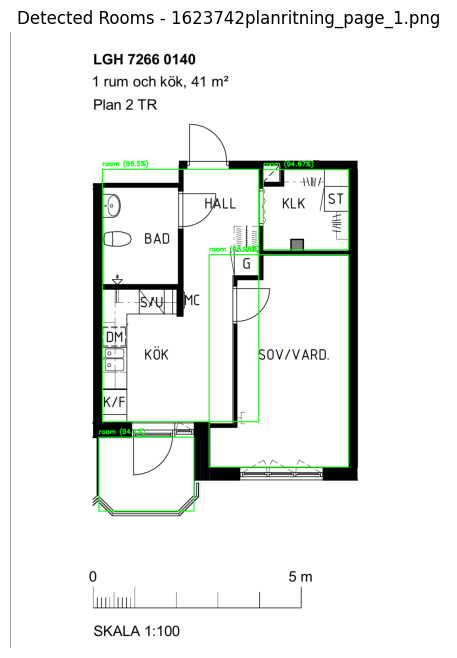

2025-03-09 18:23:20,581 - INFO - Processing image: 1635320planritning_page_1.png
2025-03-09 18:23:20,886 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\BBox_output\1635320planritning_page_1.png


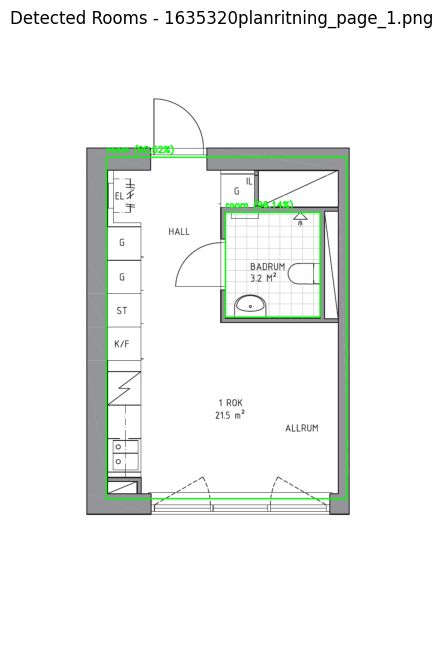

2025-03-09 18:23:22,158 - INFO - Processing image: 1637708planritning_page_1.png
2025-03-09 18:23:22,890 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\BBox_output\1637708planritning_page_1.png


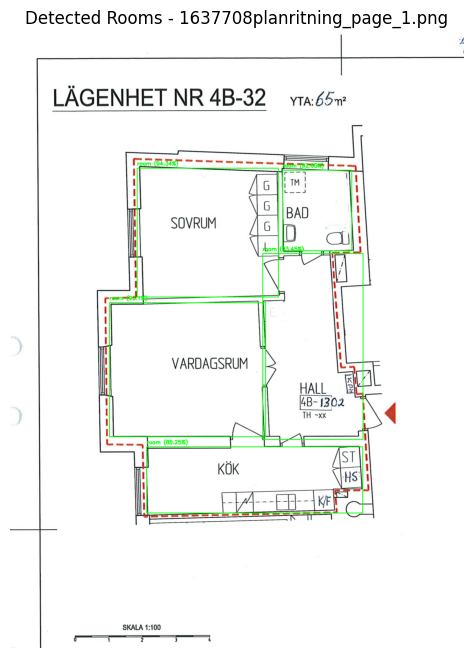

2025-03-09 18:23:24,399 - INFO - Processing image: 0_11.jpg
2025-03-09 18:23:24,899 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\BBox_output\0_11.jpg


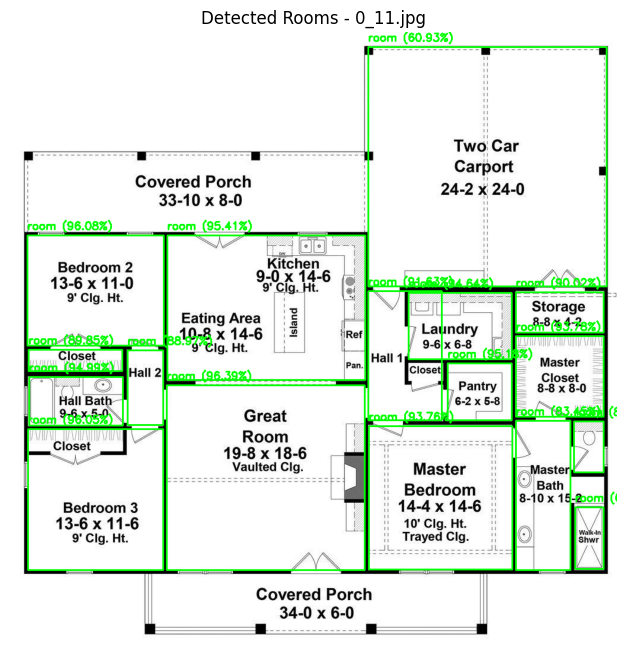

2025-03-09 18:23:26,214 - INFO - Processing image: 0_20.jpg
2025-03-09 18:23:26,930 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\BBox_output\0_20.jpg


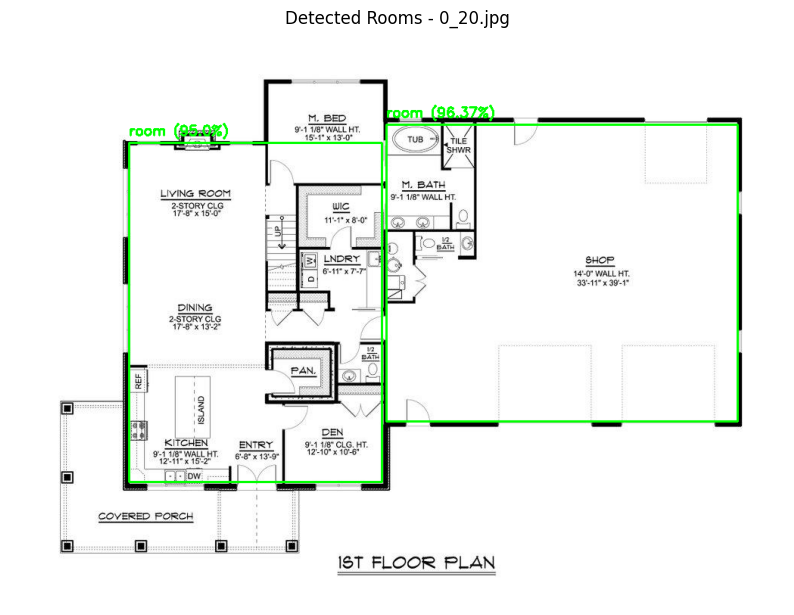

2025-03-09 18:23:28,190 - INFO - Processing image: 0_22.jpg
2025-03-09 18:23:28,556 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\BBox_output\0_22.jpg


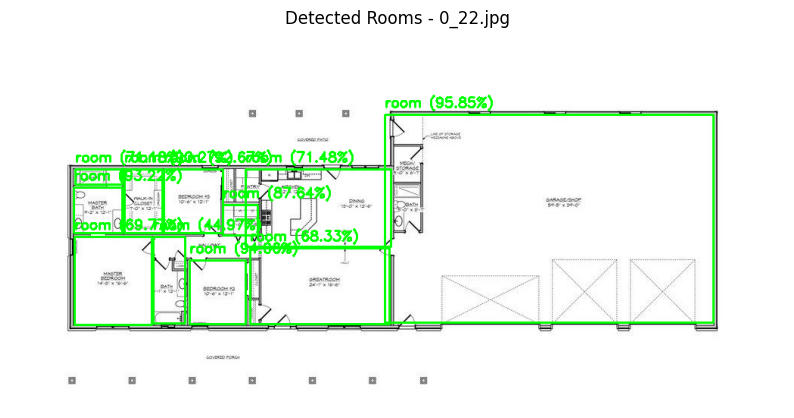

2025-03-09 18:23:29,775 - INFO - Processing image: 0_25.jpg
2025-03-09 18:23:30,266 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\BBox_output\0_25.jpg


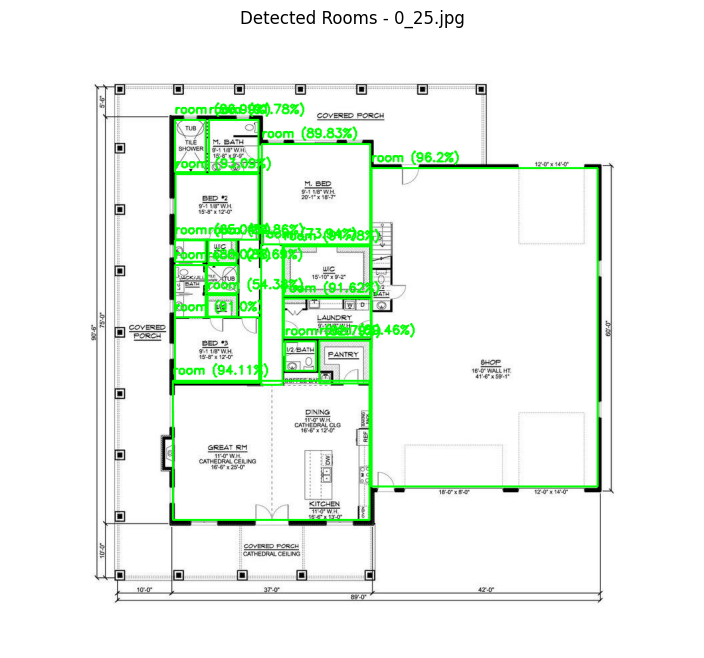

2025-03-09 18:23:31,531 - INFO - Processing image: 0_26.jpg
2025-03-09 18:23:31,869 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\BBox_output\0_26.jpg


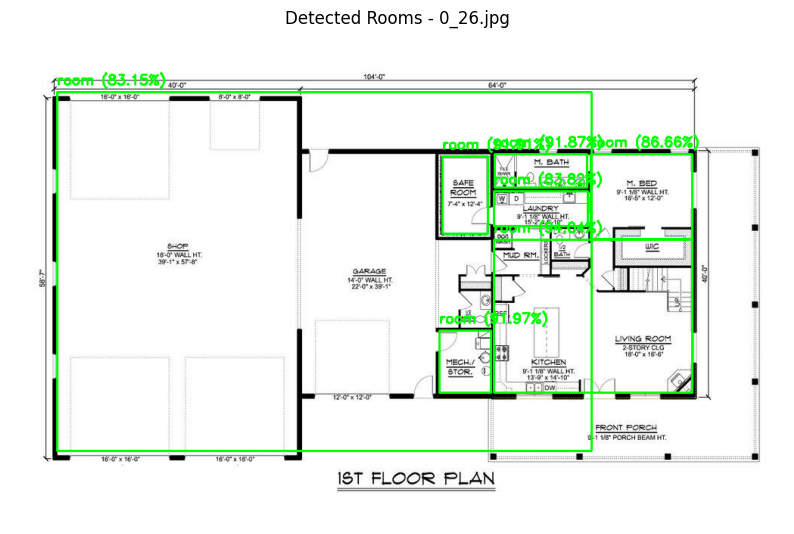

2025-03-09 18:23:33,107 - INFO - Processing image: 0_4.jpg
2025-03-09 18:23:33,459 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\BBox_output\0_4.jpg


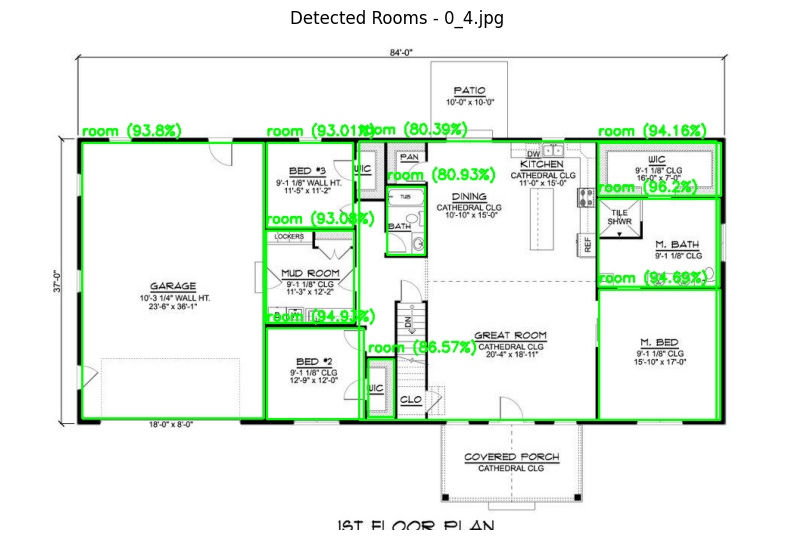

2025-03-09 18:23:34,706 - INFO - Processing image: 0_6.jpg
2025-03-09 18:23:34,988 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\BBox_output\0_6.jpg


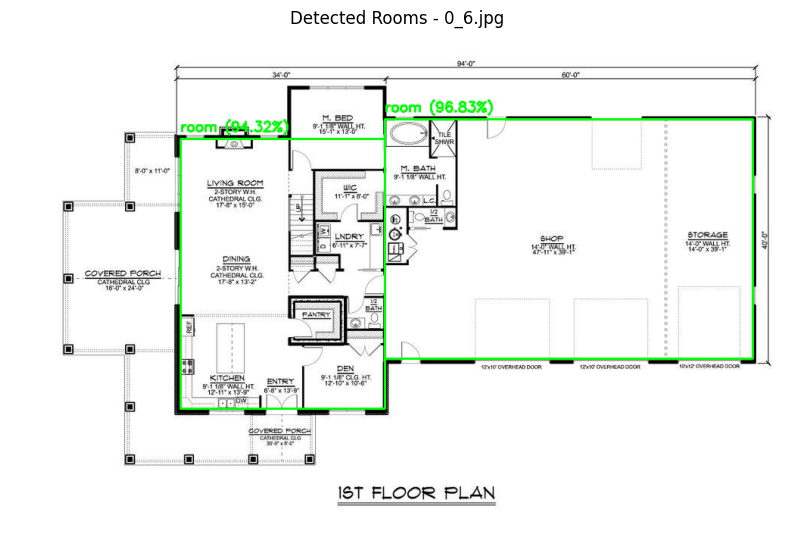

2025-03-09 18:23:36,226 - INFO - Processing image: 0_7.jpg
2025-03-09 18:23:36,683 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\BBox_output\0_7.jpg


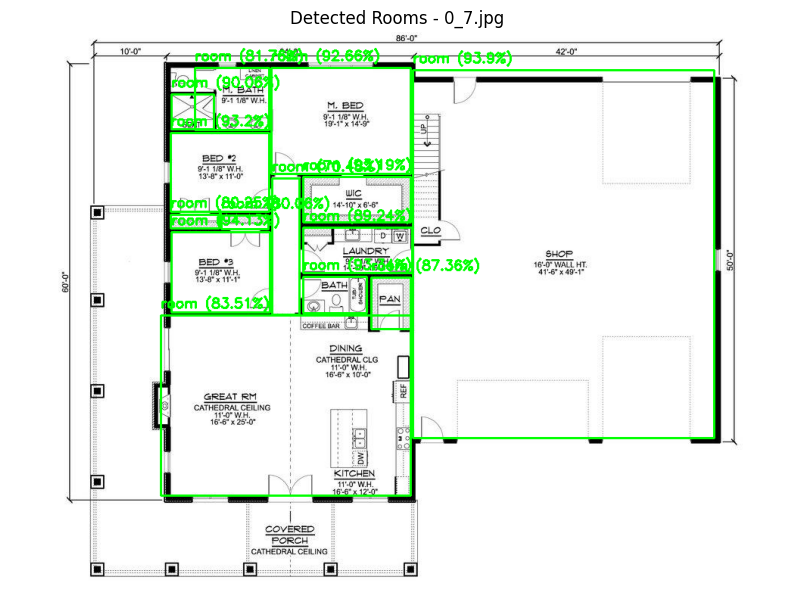

2025-03-09 18:23:37,952 - INFO - Processing image: 0_8.jpg
2025-03-09 18:23:38,477 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\BBox_output\0_8.jpg


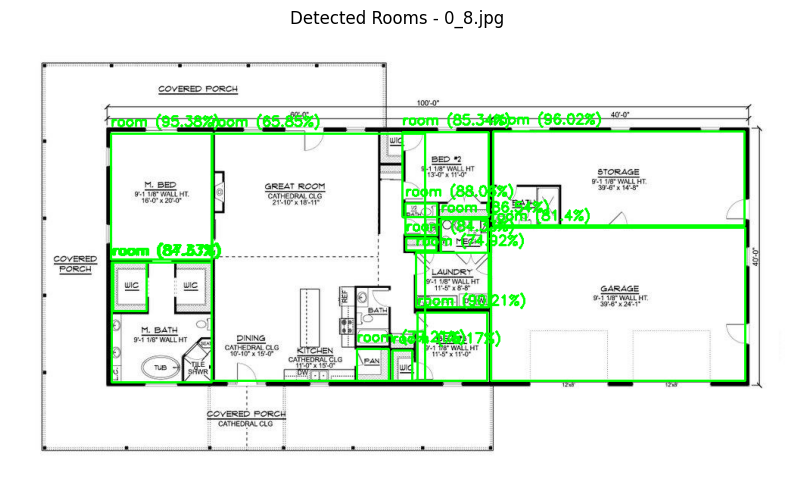

2025-03-09 18:23:39,715 - INFO - Processing image: 0_9.jpg
2025-03-09 18:23:40,080 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\BBox_output\0_9.jpg


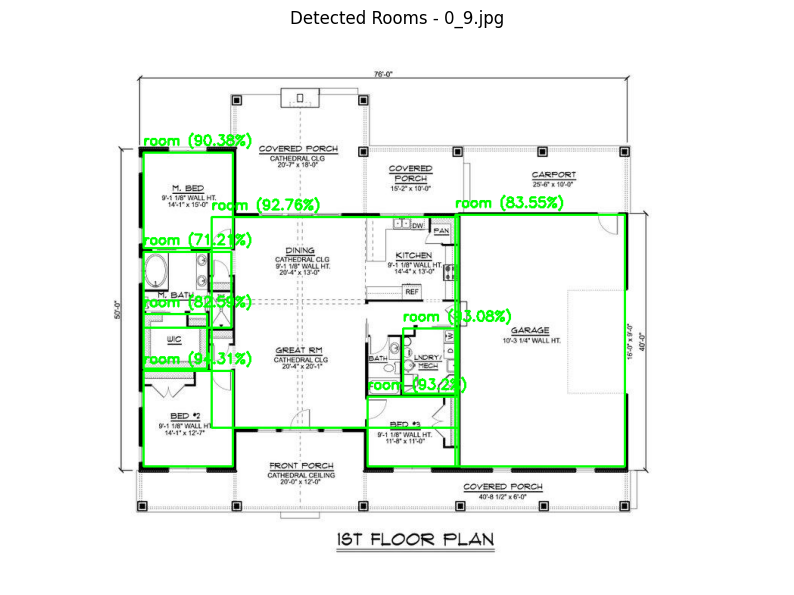

In [95]:
# Example usage:
input_folder = r"D:\IAAC\Classes\Workshops\AI Hackathon 1.4\cropped_plans"
output_folder = r"D:\IAAC\Classes\Workshops\AI Hackathon 1.4\BBox_output"
model_id = "room-detection-6nzte/1"  # RoboFlow model ID

process_folder(
    input_folder=input_folder,
    output_folder=output_folder,
    model_id=model_id,
    visualize=True  # or False if you don't want to see the plots
)


In [22]:
def get_bounding_boxes_from_detections(detections):
    """
    Extracts bounding boxes from the detection result.
    Converts center-based coordinates (x, y, width, height)
    into corner-based format: (x1, y1, x2, y2).
    
    Args:
        detections (dict): The JSON response from the RoboFlow model.
    
    Returns:
        list: A list of bounding boxes in (x1, y1, x2, y2) format.
    """
    boxes = []
    if "predictions" not in detections:
        return boxes
    for pred in detections["predictions"]:
        try:
            x = int(pred["x"])
            y = int(pred["y"])
            w = int(pred["width"])
            h = int(pred["height"])
            # Convert center-based to corner-based
            x1 = x - w // 2
            y1 = y - h // 2
            x2 = x + w // 2
            y2 = y + h // 2
            boxes.append((x1, y1, x2, y2))
        except Exception as e:
            print(f"Error converting prediction to bbox: {pred} -> {e}")
    return boxes

def inflate_bbox(bbox, inflate=5):
    """
    Inflates a bounding box by 'inflate' pixels on all sides.
    bbox: (x1, y1, x2, y2)
    Returns: (x1_inflated, y1_inflated, x2_inflated, y2_inflated)
    """
    x1, y1, x2, y2 = bbox
    return (x1 - inflate, y1 - inflate, x2 + inflate, y2 + inflate)

def compute_iou(bbox1, bbox2):
    """
    Computes the Intersection over Union (IoU) between two bounding boxes. 
    Each bbox in (x1, y1, x2, y2) format.
    """
    x1_1, y1_1, x2_1, y2_1 = bbox1
    x1_2, y1_2, x2_2, y2_2 = bbox2

    inter_x1 = max(x1_1, x1_2)
    inter_y1 = max(y1_1, y1_2)
    inter_x2 = min(x2_1, x2_2)
    inter_y2 = min(y2_1, y2_2)

    inter_w = max(0, inter_x2 - inter_x1)
    inter_h = max(0, inter_y2 - inter_y1)
    inter_area = inter_w * inter_h

    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = area1 + area2 - inter_area
    if union_area == 0:
        return 0.0
    return inter_area / union_area

def boxes_are_adjacent_inflated(bbox1, bbox2, inflate_pixels=10, iou_threshold=0.0):
    """
    Considers two boxes adjacent if their INFLATED bounding boxes
    have IoU > iou_threshold.
    
    Args:
        bbox1, bbox2: (x1, y1, x2, y2)
        inflate_pixels: how many pixels to inflate each side
        iou_threshold: e.g., 0.0 means any overlap or touch is considered adjacent
    """
    ibox1 = inflate_bbox(bbox1, inflate=inflate_pixels)
    ibox2 = inflate_bbox(bbox2, inflate=inflate_pixels)
    iou = compute_iou(ibox1, ibox2)
    return iou > iou_threshold

def boxes_are_adjacent_by_distance(bbox1, bbox2, max_gap=10):
    """
    Alternative approach: considers two boxes adjacent if they are
    'close enough' (<= max_gap pixels) horizontally or vertically.
    
    This helps if boxes are side-by-side with a small gap.
    """
    x1A, y1A, x2A, y2A = bbox1
    x1B, y1B, x2B, y2B = bbox2
    
    # If bounding boxes overlap horizontally
    # or are within 'max_gap' horizontally
    horizontal_gap = 0
    if x2A < x1B:
        horizontal_gap = x1B - x2A
    elif x2B < x1A:
        horizontal_gap = x1A - x2B
    
    # If bounding boxes overlap vertically
    # or are within 'max_gap' vertically
    vertical_gap = 0
    if y2A < y1B:
        vertical_gap = y1B - y2A
    elif y2B < y1A:
        vertical_gap = y1A - y2B
    
    # If either gap is <= max_gap, we can consider them "adjacent"
    return (horizontal_gap <= max_gap) and (vertical_gap <= max_gap)

def draw_adjacency_improved(img, bounding_boxes,
                            inflate_pixels=10, iou_threshold=0.0,
                            use_distance_check=False, max_gap=15):
    """
    Draws circles at the center of each bounding box and lines between
    centers of bounding boxes considered adjacent by either:
    - Inflated IoU check
    - Optional distance-based check (if use_distance_check=True)
    
    Args:
        img (numpy.ndarray): Image to draw on
        bounding_boxes (list): List of (x1, y1, x2, y2) bounding boxes
        inflate_pixels (int): How many pixels to inflate each bounding box
        iou_threshold (float): IoU threshold for adjacency on inflated boxes
        use_distance_check (bool): If True, also check bounding box distance
        max_gap (int): Max gap for distance-based adjacency
    
    Returns:
        numpy.ndarray: Annotated image
    """
    # 1) Draw circle for each bounding box center
    centers = []
    for (x1, y1, x2, y2) in bounding_boxes:
        cx = (x1 + x2) // 2
        cy = (y1 + y2) // 2
        centers.append((cx, cy))
        cv2.circle(img, (cx, cy), 5, (0, 0, 255), -1)
    
    # 2) Check adjacency between each pair of boxes
    n = len(bounding_boxes)
    for i in range(n):
        for j in range(i + 1, n):
            bboxA = bounding_boxes[i]
            bboxB = bounding_boxes[j]
            
            # Step A: check inflated IoU
            adjacent_inflated = boxes_are_adjacent_inflated(
                bboxA, bboxB,
                inflate_pixels=inflate_pixels,
                iou_threshold=iou_threshold
            )
            
            # Step B (optional): check distance if you want
            adjacent_distance = False
            if use_distance_check:
                adjacent_distance = boxes_are_adjacent_by_distance(
                    bboxA, bboxB,
                    max_gap=max_gap
                )
            
            # Combine logic:
            # If either inflated IoU is good OR distance check is good => adjacency
            if adjacent_inflated or adjacent_distance:
                cv2.line(img, centers[i], centers[j], (255, 0, 0), 2)
    
    return img


Extracted boxes: [(777, 220, 937, 336), (339, 391, 467, 511), (778, 340, 938, 512), (777, 146, 939, 216), (95, 146, 335, 510), (338, 262, 454, 384), (339, 146, 453, 258), (473, 432, 507, 508), (498, 204, 548, 294), (461, 144, 933, 512)]
Final annotated image saved at D:\IAAC\Classes\Workshops\AI Hackathon 1.4\anotated_output\0_4_adjacency.jpg


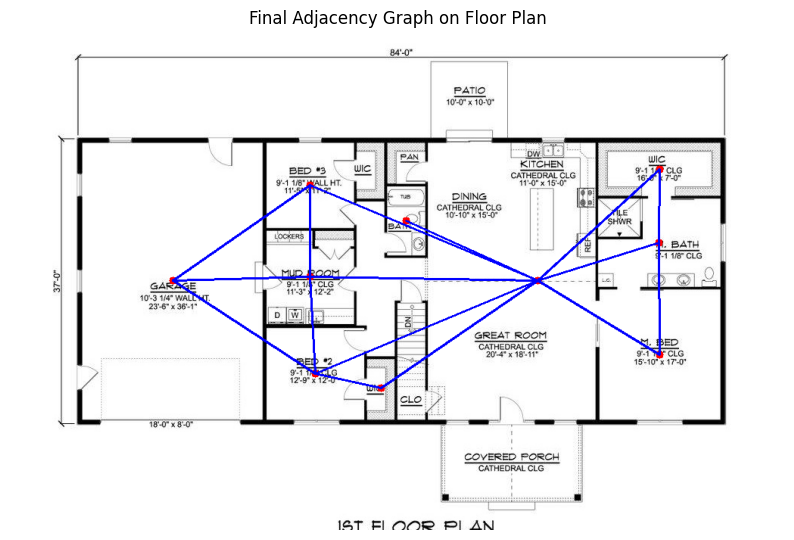

In [23]:
# For demonstration, load one of the processed images and use its detection results.
# You can also loop over all images in your output folder.

# Example: use an image from your output folder
example_image_path = r"D:\IAAC\Classes\Workshops\AI Hackathon 1.4\cropped_plans\0_4.jpg"  # adjust accordingly
# Assume you previously saved the detections or re-run inference on this image:
detections = run_inference(example_image_path, model_id="room-detection-6nzte/1")

if detections is not None:
    boxes = get_bounding_boxes_from_detections(detections)
    print("Extracted boxes:", boxes)
    
    # Load the image
    img = cv2.imread(example_image_path)
    if img is None:
        print("Error loading image.")
    else:
        # Draw the adjacency graph
        annotated_img = draw_adjacency_improved(img.copy(), boxes, iou_threshold=0.0)
        
        # Save the annotated image
        final_output_path = r"D:\IAAC\Classes\Workshops\AI Hackathon 1.4\anotated_output\0_4_adjacency.jpg"
        cv2.imwrite(final_output_path, annotated_img)
        print(f"Final annotated image saved at {final_output_path}")
        
        # Display the result
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Final Adjacency Graph on Floor Plan")
        plt.show()
else:
    print("No detections available to build adjacency graph.")


In [24]:
annotated_img = draw_adjacency_improved(
    img.copy(), boxes,
    inflate_pixels=15,      # how many pixels to inflate each box
    iou_threshold=0.0,     # or 0.01 if you want minimal overlap
    use_distance_check=True,
    max_gap=20             # max gap in pixels for adjacency
)


2025-03-09 18:23:41,885 - INFO - Processing image for adjacency: 1623742planritning_page_1.png
2025-03-09 18:23:42,213 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\detection_output_folder\1623742planritning_page_1.png
2025-03-09 18:23:42,245 - INFO - Final annotated image with adjacency saved at D:\IAAC\Classes\Workshops\AI Hackathon 1.4\adjacency_output_folder\1623742planritning_page_1.png


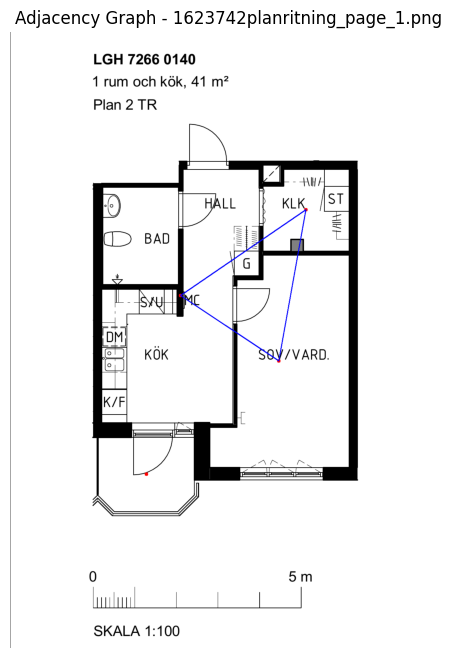

2025-03-09 18:23:44,645 - INFO - Processing image for adjacency: 1635320planritning_page_1.png
2025-03-09 18:23:44,982 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\detection_output_folder\1635320planritning_page_1.png
2025-03-09 18:23:45,001 - INFO - Final annotated image with adjacency saved at D:\IAAC\Classes\Workshops\AI Hackathon 1.4\adjacency_output_folder\1635320planritning_page_1.png


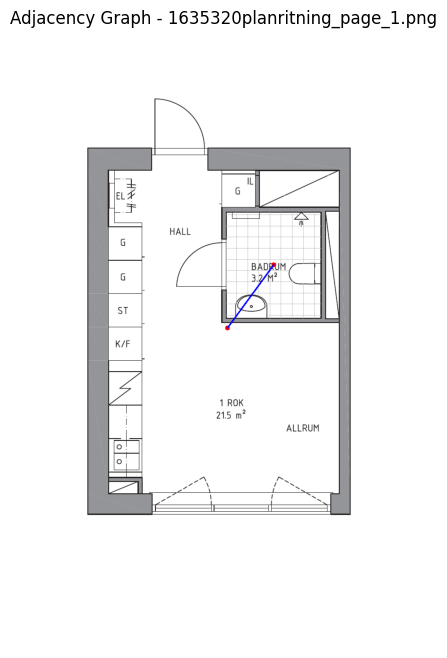

2025-03-09 18:23:47,295 - INFO - Processing image for adjacency: 1637708planritning_page_1.png
2025-03-09 18:23:48,096 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\detection_output_folder\1637708planritning_page_1.png
2025-03-09 18:23:48,167 - INFO - Final annotated image with adjacency saved at D:\IAAC\Classes\Workshops\AI Hackathon 1.4\adjacency_output_folder\1637708planritning_page_1.png


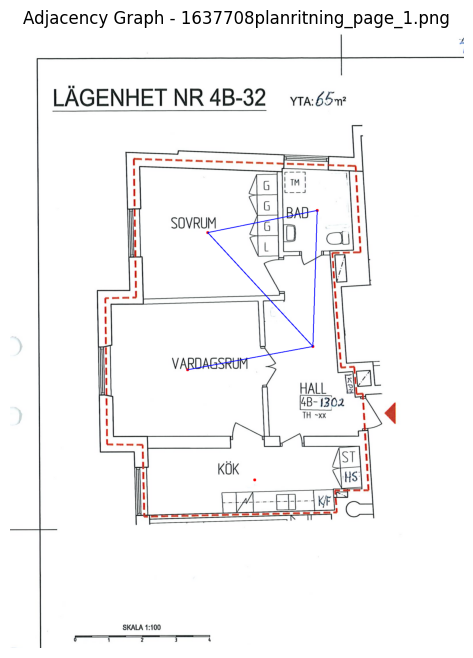

2025-03-09 18:23:50,695 - INFO - Processing image for adjacency: 0_11.jpg
2025-03-09 18:23:51,189 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\detection_output_folder\0_11.jpg
2025-03-09 18:23:51,216 - INFO - Final annotated image with adjacency saved at D:\IAAC\Classes\Workshops\AI Hackathon 1.4\adjacency_output_folder\0_11.jpg


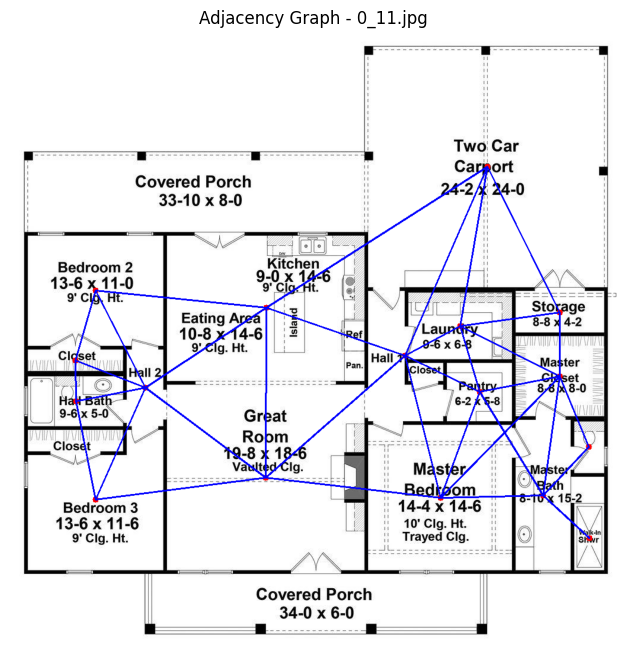

2025-03-09 18:23:53,535 - INFO - Processing image for adjacency: 0_20.jpg
2025-03-09 18:23:53,817 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\detection_output_folder\0_20.jpg
2025-03-09 18:23:53,834 - INFO - Final annotated image with adjacency saved at D:\IAAC\Classes\Workshops\AI Hackathon 1.4\adjacency_output_folder\0_20.jpg


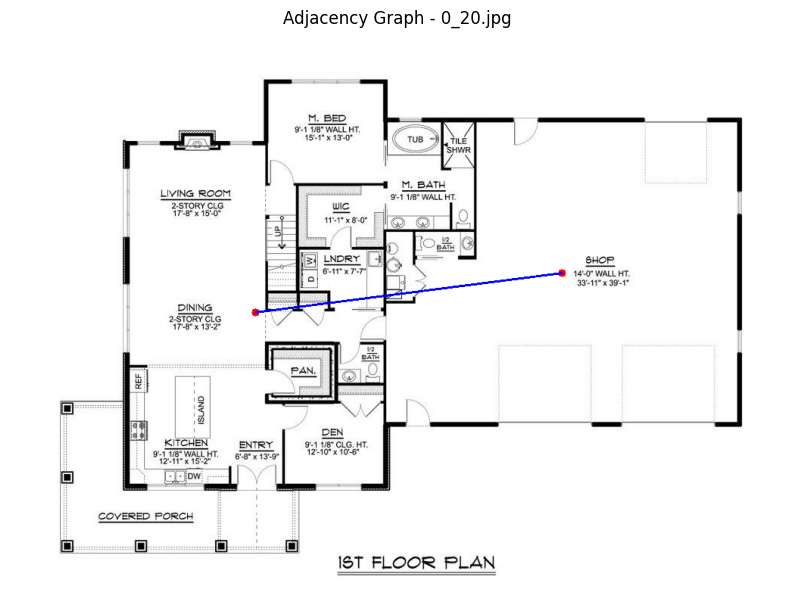

2025-03-09 18:23:56,144 - INFO - Processing image for adjacency: 0_22.jpg
2025-03-09 18:23:56,533 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\detection_output_folder\0_22.jpg
2025-03-09 18:23:56,546 - INFO - Final annotated image with adjacency saved at D:\IAAC\Classes\Workshops\AI Hackathon 1.4\adjacency_output_folder\0_22.jpg


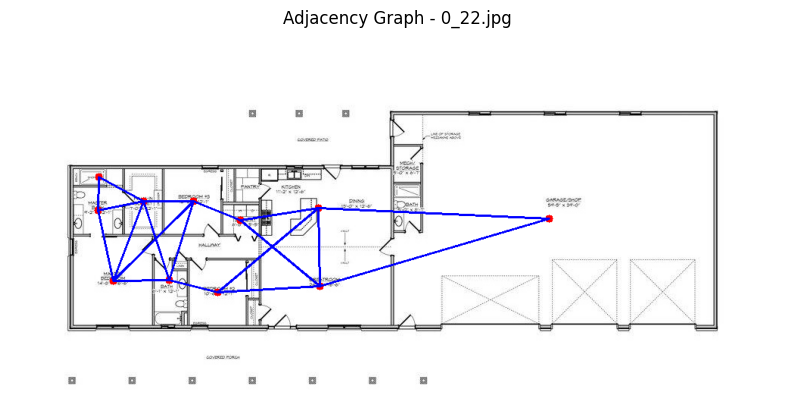

2025-03-09 18:23:58,854 - INFO - Processing image for adjacency: 0_25.jpg
2025-03-09 18:23:59,353 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\detection_output_folder\0_25.jpg
2025-03-09 18:23:59,372 - INFO - Final annotated image with adjacency saved at D:\IAAC\Classes\Workshops\AI Hackathon 1.4\adjacency_output_folder\0_25.jpg


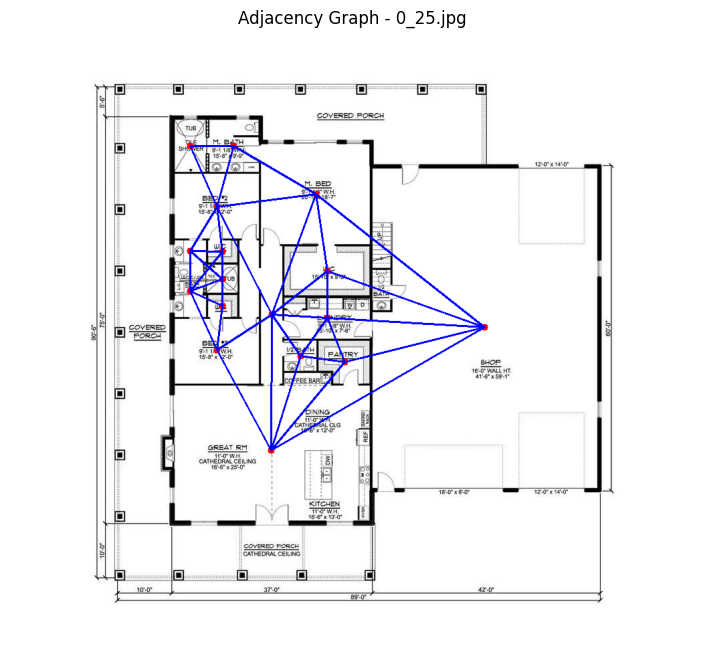

2025-03-09 18:24:01,664 - INFO - Processing image for adjacency: 0_26.jpg
2025-03-09 18:24:01,979 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\detection_output_folder\0_26.jpg
2025-03-09 18:24:01,997 - INFO - Final annotated image with adjacency saved at D:\IAAC\Classes\Workshops\AI Hackathon 1.4\adjacency_output_folder\0_26.jpg


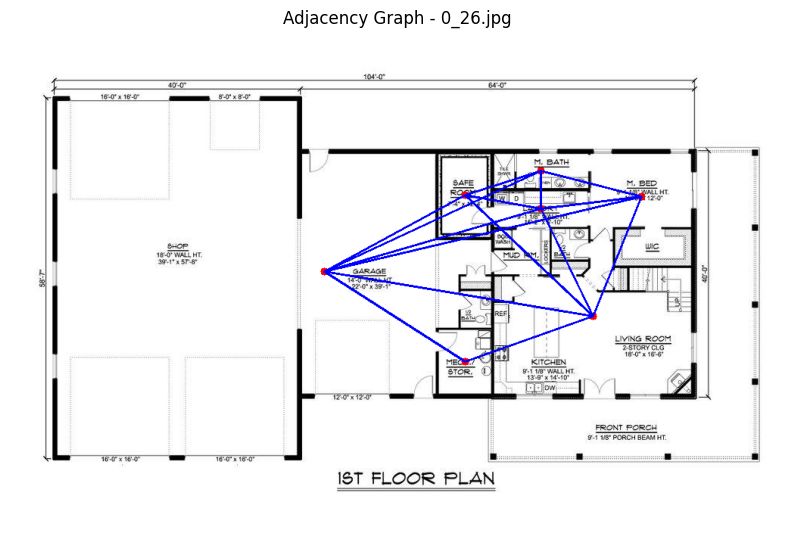

2025-03-09 18:24:04,275 - INFO - Processing image for adjacency: 0_4.jpg
2025-03-09 18:24:04,683 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\detection_output_folder\0_4.jpg
2025-03-09 18:24:04,697 - INFO - Final annotated image with adjacency saved at D:\IAAC\Classes\Workshops\AI Hackathon 1.4\adjacency_output_folder\0_4.jpg


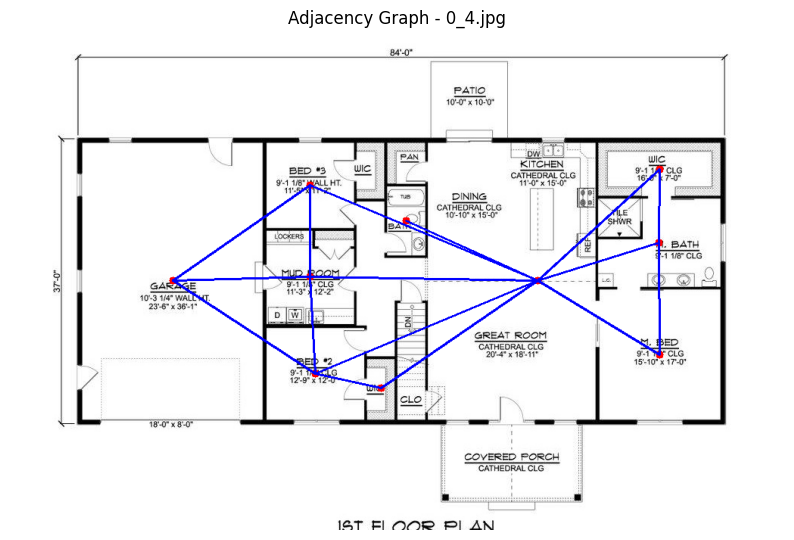

2025-03-09 18:24:06,986 - INFO - Processing image for adjacency: 0_6.jpg
2025-03-09 18:24:07,301 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\detection_output_folder\0_6.jpg
2025-03-09 18:24:07,315 - INFO - Final annotated image with adjacency saved at D:\IAAC\Classes\Workshops\AI Hackathon 1.4\adjacency_output_folder\0_6.jpg


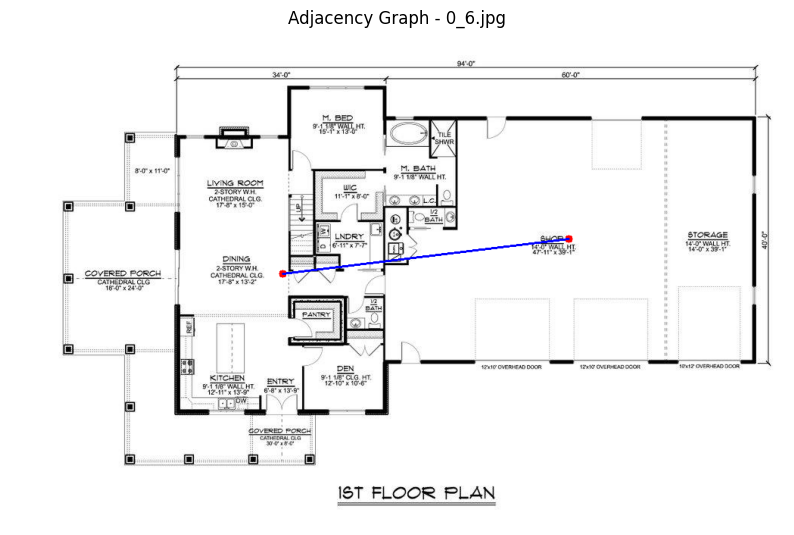

2025-03-09 18:24:09,584 - INFO - Processing image for adjacency: 0_7.jpg
2025-03-09 18:24:10,045 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\detection_output_folder\0_7.jpg
2025-03-09 18:24:10,061 - INFO - Final annotated image with adjacency saved at D:\IAAC\Classes\Workshops\AI Hackathon 1.4\adjacency_output_folder\0_7.jpg


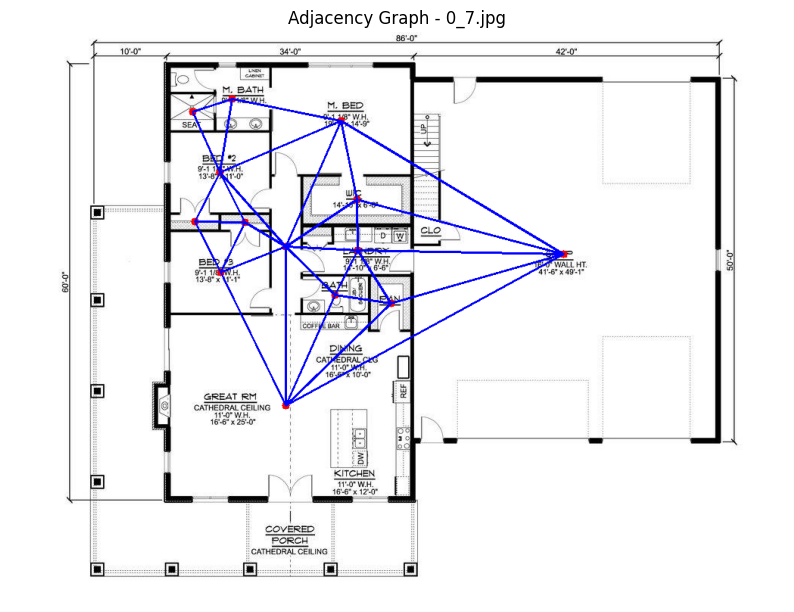

2025-03-09 18:24:12,376 - INFO - Processing image for adjacency: 0_8.jpg
2025-03-09 18:24:12,828 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\detection_output_folder\0_8.jpg
2025-03-09 18:24:12,841 - INFO - Final annotated image with adjacency saved at D:\IAAC\Classes\Workshops\AI Hackathon 1.4\adjacency_output_folder\0_8.jpg


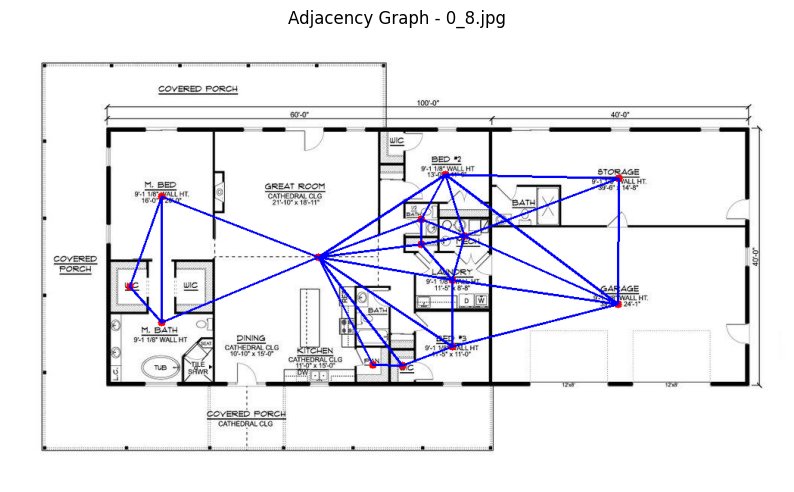

2025-03-09 18:24:15,117 - INFO - Processing image for adjacency: 0_9.jpg
2025-03-09 18:24:15,452 - INFO - Saved processed image: D:\IAAC\Classes\Workshops\AI Hackathon 1.4\detection_output_folder\0_9.jpg
2025-03-09 18:24:15,468 - INFO - Final annotated image with adjacency saved at D:\IAAC\Classes\Workshops\AI Hackathon 1.4\adjacency_output_folder\0_9.jpg


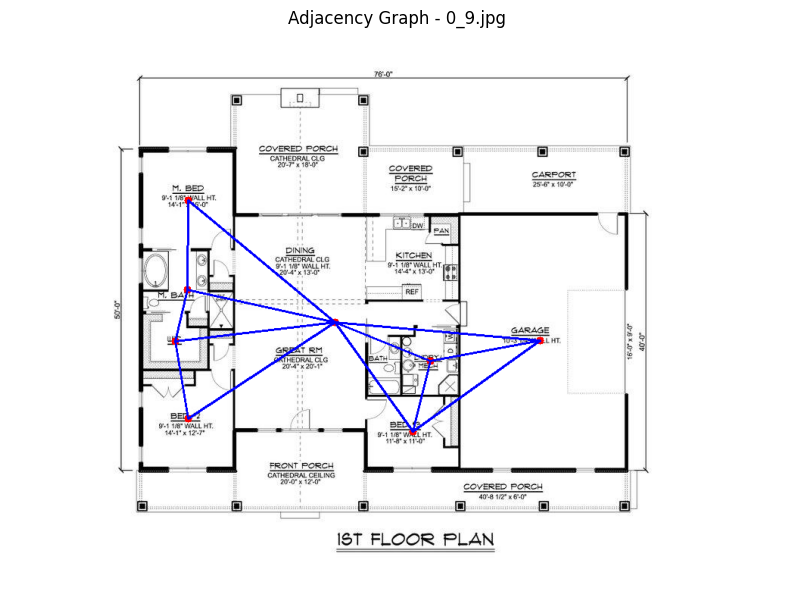

In [100]:
def process_folder_with_adjacency(input_folder, detection_output_folder, adjacency_output_folder, model_id="room-detection-6nzte/1", iou_threshold=0.0, visualize=False):
    """
    Processes each image in the input folder:
    1. Runs the RoboFlow model to detect rooms and saves the image with bounding boxes.
    2. Extracts bounding boxes from detections and draws an adjacency graph.
    3. Saves the final annotated image with the adjacency graph.
    """
    input_path = Path(input_folder)
    detection_output_path = Path(detection_output_folder)
    adjacency_output_path = Path(adjacency_output_folder)
    adjacency_output_path.mkdir(parents=True, exist_ok=True)
    
    image_files = list(input_path.glob("*.png")) + list(input_path.glob("*.jpg"))
    if not image_files:
        logging.warning(f"No image files found in {input_folder}")
        return

    for img_path in image_files:
        logging.info(f"Processing image for adjacency: {img_path.name}")
        # Run detection and save bounding boxes (if not already processed)
        detections = run_inference(img_path, model_id=model_id)
        if detections is None:
            continue
        _ = draw_and_save_detections(img_path, detections, detection_output_path)
        
        # Extract bounding boxes and draw adjacency
        boxes = get_bounding_boxes_from_detections(detections)
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        final_img = draw_adjacency_improved(img.copy(), boxes, iou_threshold=iou_threshold)
        output_file = adjacency_output_path / img_path.name
        cv2.imwrite(str(output_file), final_img)
        logging.info(f"Final annotated image with adjacency saved at {output_file}")
        if visualize:
            plt.figure(figsize=(10, 8))
            plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
            plt.axis("off")
            plt.title(f"Adjacency Graph - {img_path.name}")
            plt.pause(2)
            plt.close()

# Example integration call (adjust paths accordingly):
process_folder_with_adjacency(
    input_folder=r"D:\IAAC\Classes\Workshops\AI Hackathon 1.4\cropped_plans",
    detection_output_folder=r"D:\IAAC\Classes\Workshops\AI Hackathon 1.4\detection_output_folder",
    adjacency_output_folder=r"D:\IAAC\Classes\Workshops\AI Hackathon 1.4\adjacency_output_folder",
    model_id="room-detection-6nzte/1",
    iou_threshold=0.0,
    visualize=True
)


In [25]:
def draw_colored_boxes_random(
    img,
    bounding_boxes,
    adjacency_func,
    inflate_pixels=15,
    iou_threshold=0.0,
    alpha=0.3,
    line_color=(255, 0, 0),     # color for adjacency lines
    circle_color=(0, 0, 255),   # color for center circles
    circle_radius=6,
    line_thickness=2,
    seed=42
):
    """
    Draws each bounding box in a different random color (semi-transparent fill),
    then outlines them in the same color. Also draws adjacency lines and center circles.
    
    Args:
        img (numpy.ndarray): Original image (BGR).
        bounding_boxes (list): List of (x1, y1, x2, y2) bounding boxes.
        adjacency_func (callable): Function to determine if two boxes are adjacent.
        inflate_pixels (int): Pixels to inflate for adjacency checks (if adjacency_func uses it).
        iou_threshold (float): IoU threshold or similar param for adjacency.
        alpha (float): Transparency for the box fill [0..1].
        line_color (tuple): BGR color for adjacency lines.
        circle_color (tuple): BGR color for the center circle.
        circle_radius (int): Radius of the center circle.
        line_thickness (int): Thickness for adjacency lines.
        seed (int): Random seed to ensure reproducible colors if desired.

    Returns:
        numpy.ndarray: The annotated image with random-colored boxes + adjacency lines.
    """
    # For reproducible random colors
    random.seed(seed)

    overlay = img.copy()
    h, w = img.shape[:2]

    # Generate a random color for each bounding box
    random_colors = []
    for _ in bounding_boxes:
        color = (random.randint(0, 255),
                 random.randint(0, 255),
                 random.randint(0, 255))
        random_colors.append(color)

    centers = []
    # 1) Draw filled rectangles on the overlay
    for i, (x1, y1, x2, y2) in enumerate(bounding_boxes):
        cv2.rectangle(overlay, (x1, y1), (x2, y2), random_colors[i], -1)

        # Compute center
        cx = (x1 + x2) // 2
        cy = (y1 + y2) // 2
        centers.append((cx, cy))

    # Blend overlay onto original image with alpha
    annotated_img = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)

    # 2) Draw bounding box outlines (non-transparent) in the same random color
    for i, (x1, y1, x2, y2) in enumerate(bounding_boxes):
        cv2.rectangle(annotated_img, (x1, y1), (x2, y2), random_colors[i], 2)

    # 3) Draw circles at centers
    for (cx, cy) in centers:
        cv2.circle(annotated_img, (cx, cy), circle_radius, circle_color, -1)

    # 4) Adjacency lines
    n = len(bounding_boxes)
    for i in range(n):
        for j in range(i + 1, n):
            bboxA = bounding_boxes[i]
            bboxB = bounding_boxes[j]
            if adjacency_func(bboxA, bboxB, inflate_pixels=inflate_pixels, iou_threshold=iou_threshold):
                cv2.line(annotated_img, centers[i], centers[j], line_color, line_thickness)

    return annotated_img


Saved random-colored adjacency image to D:\IAAC\Classes\Workshops\AI Hackathon 1.4\anotated_output\0_4_colored_random.jpg


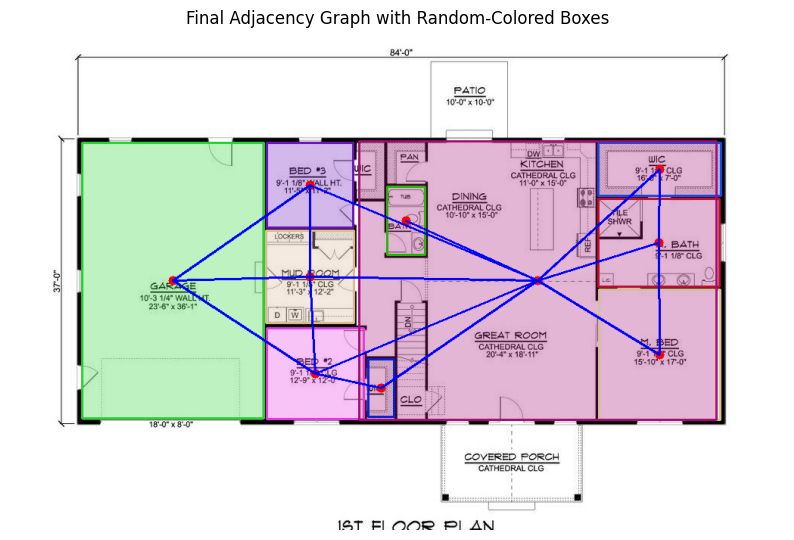

In [31]:
# Suppose you have:
# 1. img: your floor plan image (cv2.imread)
# 2. boxes: list of (x1, y1, x2, y2) from detections
# 3. adjacency_func: e.g., boxes_are_adjacent_inflated

annotated_img_random = draw_colored_boxes_random(
    img=deepcopy(img),
    bounding_boxes=boxes,
    adjacency_func=boxes_are_adjacent_inflated,  # or your adjacency function
    inflate_pixels=15,
    iou_threshold=0.0,
    alpha=0.3,
    line_color=(255, 0, 0),    # adjacency lines color
    circle_color=(0, 0, 255),  # center circle color
    circle_radius=6,
    line_thickness=2,
    seed=37 # set this for reproducible color
)

output_path = r"D:\IAAC\Classes\Workshops\AI Hackathon 1.4\anotated_output\0_4_colored_random.jpg"
cv2.imwrite(output_path, annotated_img_random)
print(f"Saved random-colored adjacency image to {output_path}")

# Display
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(annotated_img_random, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Final Adjacency Graph with Random-Colored Boxes")
plt.show()


In [103]:
def process_colored_adjacency(
    input_folder=r"D:\IAAC\Classes\Workshops\AI Hackathon 1.4\cropped_plans",
    output_folder=r"D:\IAAC\Classes\Workshops\AI Hackathon 1.4\colored_bbox",
    model_id="room-detection-6nzte/1",
    adjacency_func=boxes_are_adjacent_inflated,
    inflate_pixels=15,
    iou_threshold=0.0,
    alpha=0.3
):
    """
    Processes all images in 'input_folder' by:
      1) Running inference on each image (model_id).
      2) Extracting bounding boxes.
      3) Drawing random-colored boxes + adjacency lines with 'draw_colored_boxes_random'.
      4) Saving annotated images to 'output_folder'.
    
    Args:
        input_folder (str): Folder with images (PNG/JPG).
        output_folder (str): Folder to save annotated images.
        model_id (str): RoboFlow model ID for inference.
        adjacency_func (callable): Function to check adjacency between boxes.
        inflate_pixels (int): Pixels to inflate each box for adjacency checks.
        iou_threshold (float): IoU threshold or parameter for adjacency_func.
        alpha (float): Transparency for bounding box fill (0..1).
    """
    input_path = Path(input_folder)
    output_path = Path(output_folder)
    output_path.mkdir(parents=True, exist_ok=True)
    
    valid_exts = {".png", ".jpg", ".jpeg"}
    image_files = [p for p in input_path.iterdir() if p.suffix.lower() in valid_exts]

    for img_file in image_files:
        print(f"\nProcessing {img_file.name}...")

        # 1) Run inference
        detections = run_inference(str(img_file), model_id=model_id)
        if detections is None or "predictions" not in detections:
            print("No valid detections, skipping.")
            continue

        # 2) Extract bounding boxes
        boxes = get_bounding_boxes_from_detections(detections)
        if not boxes:
            print("No bounding boxes extracted, skipping.")
            continue

        # Load the image
        img = cv2.imread(str(img_file))
        if img is None:
            print("Error loading image, skipping.")
            continue

        # 3) Draw random-colored boxes + adjacency lines
        annotated_img = draw_colored_boxes_random(
            img=img.copy(),
            bounding_boxes=boxes,
            adjacency_func=adjacency_func,
            inflate_pixels=inflate_pixels,
            iou_threshold=iou_threshold,
            alpha=alpha,
            line_color=(255, 0, 0),
            circle_color=(0, 0, 255),
            circle_radius=6,
            line_thickness=2,
            seed=42  # set seed for reproducible colors
        )

        # 4) Save annotated image
        out_path = output_path / img_file.name
        cv2.imwrite(str(out_path), annotated_img)
        print(f"Saved annotated image to {out_path}")

# Example usage:
process_colored_adjacency()



Processing 0_11.jpg...
Saved annotated image to D:\IAAC\Classes\Workshops\AI Hackathon 1.4\colored_bbox\0_11.jpg

Processing 0_20.jpg...
Saved annotated image to D:\IAAC\Classes\Workshops\AI Hackathon 1.4\colored_bbox\0_20.jpg

Processing 0_22.jpg...
Saved annotated image to D:\IAAC\Classes\Workshops\AI Hackathon 1.4\colored_bbox\0_22.jpg

Processing 0_25.jpg...
Saved annotated image to D:\IAAC\Classes\Workshops\AI Hackathon 1.4\colored_bbox\0_25.jpg

Processing 0_26.jpg...
Saved annotated image to D:\IAAC\Classes\Workshops\AI Hackathon 1.4\colored_bbox\0_26.jpg

Processing 0_4.jpg...
Saved annotated image to D:\IAAC\Classes\Workshops\AI Hackathon 1.4\colored_bbox\0_4.jpg

Processing 0_6.jpg...
Saved annotated image to D:\IAAC\Classes\Workshops\AI Hackathon 1.4\colored_bbox\0_6.jpg

Processing 0_7.jpg...
Saved annotated image to D:\IAAC\Classes\Workshops\AI Hackathon 1.4\colored_bbox\0_7.jpg

Processing 0_8.jpg...
Saved annotated image to D:\IAAC\Classes\Workshops\AI Hackathon 1.4\col